In [5]:
###lpr
import numpy as np
import scipy as sp
from scipy import signal
import arrayfire as af
from numba import jit
###fpca
from scipy import interpolate
#我##了5個autojit
import random
###simulation
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time

import pandas as pd
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
import fpca

In [7]:
#################################
def EigF1(t):
    return(np.sin(2 * np.pi * t) * np.sqrt(2))

def EigF2(t):
    return(np.sin(4 * np.pi * t) * np.sqrt(2))

def MeanF(t):
    return(np.exp((t - 0.5)**2))

def CovF(s, t):
    return(eig_val[0] * EigF1(s) * EigF1(t) + eig_val[1] * EigF2(s) * EigF2(t))

In [10]:
eig_val = np.array([4, 1])
sigma2 = 0.16
num_grid = 401
num_fun = 500
num_pt = num_grid
d = 1

t1 = np.linspace(0, 1, num_grid)
t_grid = t1

In [11]:
real_mean = MeanF(t_grid)
real_cov = CovF(t_grid.repeat(num_grid), np.tile(t_grid, num_grid)).reshape(num_grid**2, -1)
real_cov_dia = np.diag(real_cov)
real_eigfun1 = EigF1(t_grid)
real_eigfun2 = EigF2(t_grid)

In [12]:
np.random.seed(101)

t_of_fun = t1.repeat(num_fun).reshape(-1, num_fun).T

pc_score = np.array((np.random.normal(0, np.sqrt(eig_val[0]), num_fun),
                  np.random.normal(0, np.sqrt(eig_val[1]), num_fun))).reshape(2, num_fun).T

epsilon = np.array(np.random.normal(0, np.sqrt(sigma2), (num_fun, num_pt)))

eigf1 = EigF1(t_of_fun).reshape(num_fun, num_pt)
eigf2 = EigF2(t_of_fun).reshape(num_fun, num_pt)
meanf = MeanF(t_of_fun).reshape(num_fun, num_pt)
eigf = np.array([eigf1, eigf2])

y = np.zeros_like(eigf1)
for n_f in range(num_fun):
    y[n_f] = meanf.take(n_f, 0) + pc_score.take(n_f, 0).dot(eigf.take(n_f, 1))

y = y + epsilon

In [13]:
candidate_h_mean = np.arange(0.1, 0.6, 0.05).reshape(-1, d)
candidate_h_cov = np.arange(0.05, 0.55, 0.05).repeat(2).reshape(-1, 2 * d)
candidate_h_diag_cov = np.arange(0.05, 0.55, 0.05).reshape(-1, d)

In [14]:
fpca.lpr.Set_arrayfire_backend('cpu')
#fpca.lpr.Set_arrayfire_backend('opencl')
#fpca.lpr.Set_arrayfire_backend('cuda')

In [15]:
pre_time = time.time()
result = fpca.Fpca(x = list(t_of_fun.reshape(num_fun, num_pt, d)),
                   y = list(y.reshape(num_fun, num_pt)),
                   x0 = t_grid.reshape(num_grid, d), 
                   h_mean = candidate_h_mean,
                   h_cov = candidate_h_cov,
                   h_cov_dia = candidate_h_diag_cov,
                   bin_weight = False,
                   fve = 0.99,
                   dtype = 'f4')
time.time() - pre_time

/home/shuanjeng/桌面/python/NCHUproject/fpca.py:151: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "__Fit_Mean" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/shuanjeng/桌面/python/NCHUproject/fpca.py (153)

File "fpca.py", line 153:
    def __Fit_Mean(self, x, y, x0, candidate_h, binning, bin_weight, ker_fun, bw_select, dtype, bin_data = None):
        if binning == True:
        ^

  @jit(cache=True)
/home/shuanjeng/miniconda3/lib/python3.7/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "__Fit_Mean" was compiled in object mode without forceobj=True.

File "fpca.py", line 152:
    @jit(cache=True)
    def __Fit_Mean(self, x, y, x0, candidate_h, binning, bin_weight, ker_fun, bw_select, dtype, bin_data = None):
    ^

  state.func_ir.loc))
/home/shuanjeng/miniconda3/lib/python3.7/site-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back

/home/shuanjeng/桌面/python/NCHUproject/fpca.py:202: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "__Get_Row_Cov" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/shuanjeng/桌面/python/NCHUproject/fpca.py (204)

File "fpca.py", line 204:
    def __Get_Row_Cov(self, x, y, cov_x0, binning, bin_weight, bin_data = None):
        cov_grid_shape = cov_x0.shape[:-1]
        ^

  @jit(cache=True)
/home/shuanjeng/桌面/python/NCHUproject/fpca.py:202: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "__Get_Row_Cov" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "fpca.py", line 211:
    def __Get_Row_Cov(self, x, y, cov_x0, binning, bin_weight, bin_data = None):
        <source elided>
            bin_cov_data = np.asarray([bin_cov_y, bin_cov_x])
            for i in range(num_fun):
         

60.402661085128784

In [16]:
print(result)

Number of grid: 401
Number of random function: 500
Eigen pairs: 2
Sigma2: 0.266789
Bandwidth of mean: [0.40000000000000013]
Bandwidth of cov: [0.05, 0.05]
Bandwidth of cov_diag: [0.05]


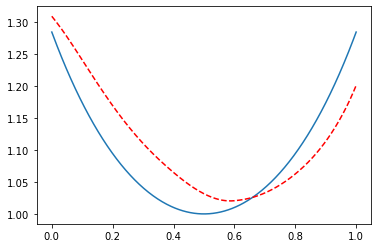

In [17]:
fig1 = plt.figure(1)
plt.plot(t1, real_mean)
plt.plot(t1, result.mean_fun, '--r')

plt.show()

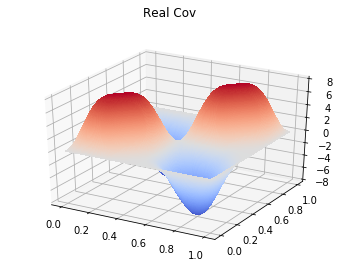

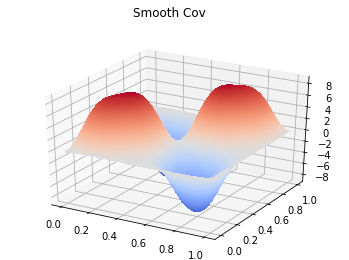

In [18]:
fig1 = plt.figure(1)
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       real_cov.reshape(num_grid, num_grid),
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)
ax.set_zlim3d(-8, 8)
plt.suptitle('Real Cov')

fig2 = plt.figure(2)
ax = fig2.gca(projection='3d')
surf = ax.plot_surface(t1.repeat(t1.size).reshape(num_grid, num_grid), 
                       np.tile(t1, t1.size).reshape(num_grid, num_grid), 
                       result.cov_fun,
                       rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0.1, antialiased=False)

plt.suptitle('Smooth Cov')
plt.show()

Real eigen values: 4, 1
Fitted eigen values: 4.36527, 1.01814


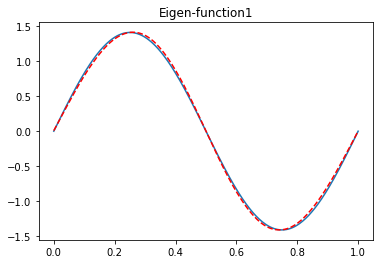

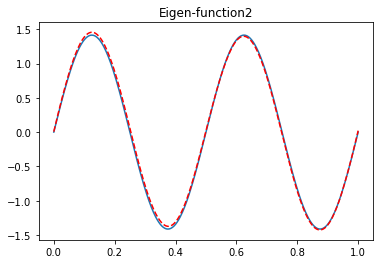

In [19]:
print("Real eigen values: %s" %", ".join(map(str, eig_val)))
print("Fitted eigen values: %s" %", ".join(map(str, np.round(result.eig_val[0:2], 5))))

fig1 = plt.figure(1)
plt.plot(t1, real_eigfun1)
direction1 = 1 if (real_eigfun1.dot(result.eig_fun[0]) > 0) else -1
plt.plot(t1, direction1 * result.eig_fun[0], '--r')
plt.title('Eigen-function1')

fig2 = plt.figure(2)
plt.plot(t1, real_eigfun2)
direction2 = 1 if (real_eigfun2.dot(result.eig_fun[1]) > 0) else -1
plt.plot(t1, direction2 * result.eig_fun[1], '--r')
plt.title('Eigen-function2')

plt.show()

In [20]:
print("Real eigen values: %s" %", ".join(map(str, eig_val)))
print("Fitted eigen values of result: %s" %", ".join(map(str, result.eig_val[0:2])))

Real eigen values: 4, 1
Fitted eigen values of result: 4.3652716, 1.0181432


In [21]:
print('Estimate fpc scores by PACE')
mse_pc = np.mean((pc_score - result.fpc_scores[:, 0:2] * np.array([direction1, direction2]))**2, axis = 0)
print('MSE of fpc_scores: %s' %", ".join(map(str, mse_pc)))

Estimate fpc scores by PACE
MSE of fpc_scores: 0.0030989939451004198, 0.004613367659734709


In [22]:
print("Real Sigma2: %f" %sigma2)
print("Fitted Sigma2: %f" %result.sigma2)

Real Sigma2: 0.160000
Fitted Sigma2: 0.266789


In [23]:
restruct_pc_score, fit_x1_to_x4 = result.Restruct_Fun(list(t_of_fun.reshape(num_fun, num_pt, d).take(np.arange(4), 0)), 
                                                      list(y.reshape(num_fun, num_pt).take(np.arange(4), 0)))

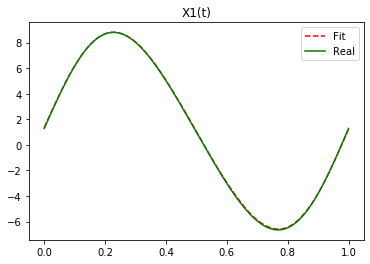

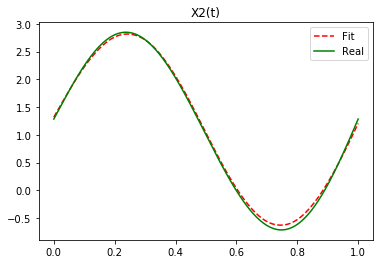

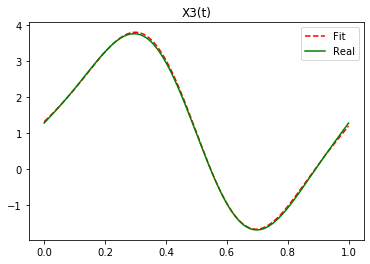

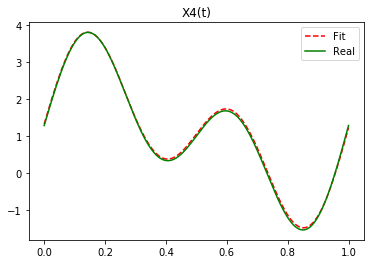

In [24]:
for i in range(4):
    fig = plt.figure(i)
    sort_order = np.argsort(t_of_fun[i])
    plt.plot(t1, fit_x1_to_x4[i], '--r', label = 'Fit')
    plt.plot(t1, real_mean + pc_score.take(i, 0).dot(np.asarray([real_eigfun1, real_eigfun2])), 'green', label = 'Real')
    plt.legend(loc = 1)
    plt.title('X' + str(i + 1) + '(t)')
#     fig.savefig('d:/Work_Jupyter/Gpu/Picture/1d_regular_X' + str(i + 1) + '.png')
plt.show()

In [25]:
dt = 1 / (num_grid - 1)

ISE = np.zeros(num_fun)
fit_x = result.Restruct_Fun(t_of_fun.reshape(num_fun, num_pt, d), y.reshape(num_fun, num_pt))[1]

for i in range(num_fun):
    sort_order = np.argsort(t_of_fun[i])
    ISE[i] = np.sum((fit_x.take(i, 0) - (real_mean + pc_score.take(i, 0).dot(np.asarray([real_eigfun1, real_eigfun2]))))**2) * dt

MISE = ISE.mean()
print(MISE)

0.001982842784025929
